## План работы:
- подключаемся к trino
- создаем таблицы в post

In [125]:
import trino
import matplotlib.pyplot as plt
import pandas as pd

Для начала подключимся

In [4]:
conn = trino.dbapi.connect(
    host="host.docker.internal",   
    port=8080,
    user="student",
    catalog="iceberg",
    schema="demo",
)
cur = conn.cursor()

def q(sql):
    cur.execute(sql)
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns=[c[0] for c in cur.description]) if cur.description else None

## Схемы и таблицы в бд
Проверим схемы и таблицы в базе постгрес

In [109]:
q("SHOW SCHEMAS FROM postgres")

,Schema
0,iceberg
1,information_schema
2,pg_catalog
3,public


In [111]:
q("SHOW TABLES FROM postgres.public")

,Table
0,trn_customers
1,trn_events
2,trn_orders


Проверим схемы и таблицы в базе mysql

In [108]:
q("SHOW SCHEMAS FROM mysql")

,Schema
0,demo_db
1,information_schema
2,performance_schema


In [110]:
q("SHOW TABLES FROM mysql.demo_db")

,Table
0,trn_payments


В dbeavere дропнул таблицы, но для того чтобы показать что тут через трино можно создать и наполнить таблицы я создам и наполню таблицы в базах

In [14]:
q(""" CREATE TABLE postgres.public.trn_customers (
  customer_id integer,
  customer_name varchar,
  country varchar,
  created_at timestamp
)"""
 )

In [15]:
q(""" CREATE TABLE postgres.public.trn_orders (
  order_id integer,
  customer_id integer,
  order_ts timestamp,
  total_amount double
)"""
 )

In [16]:
q(""" CREATE TABLE postgres.public.trn_events (
  event_id bigint,
  user_id integer,
  event_time timestamp,
  event_name varchar
)"""
 )

In [17]:
q(""" CREATE TABLE mysql.demo_db.trn_payments (
  payment_id bigint,
  order_id bigint,
  amount double,
  paid_at timestamp(3)
)"""
 )

In [18]:
q("""
INSERT INTO postgres.public.trn_customers (customer_id, customer_name, country, created_at)
SELECT
  x AS customer_id,
  CONCAT('Customer ', CAST(x AS varchar)) AS customer_name,
  CASE (x % 6)
    WHEN 0 THEN 'DE'
    WHEN 1 THEN 'NL'
    WHEN 2 THEN 'FR'
    WHEN 3 THEN 'PL'
    WHEN 4 THEN 'ES'
    ELSE 'IT'
  END AS country,
  current_timestamp - INTERVAL '1' DAY * CAST(rand() * 365 AS integer) AS created_at
FROM UNNEST(sequence(1, 200)) AS t(x)
""")

,rows
0,200


In [19]:
q("""
INSERT INTO postgres.public.trn_orders (order_id, customer_id, order_ts, total_amount)
WITH c AS (
  SELECT customer_id, row_number() OVER (ORDER BY customer_id) AS rn
  FROM postgres.public.trn_customers
),
cnt AS (SELECT MAX(rn) AS n FROM c)
SELECT
  x AS order_id,
  c.customer_id,
  current_timestamp
    - INTERVAL '1' DAY * CAST(rand() * 180 AS integer)
    - INTERVAL '1' MINUTE * CAST(rand() * 1440 AS integer) AS order_ts,
  round(10 + rand() * 490, 2) AS total_amount
FROM UNNEST(sequence(1, 1000)) AS t(x)
CROSS JOIN cnt
JOIN c ON c.rn = ((x - 1) % cnt.n) + 1
""")

,rows
0,1000


In [20]:
q("""
INSERT INTO postgres.public.trn_events (event_id, user_id, event_time, event_name)
WITH o AS (
  SELECT
    order_id,
    customer_id AS user_id,
    order_ts,
    row_number() OVER (ORDER BY order_id) AS rn
  FROM postgres.public.trn_orders
),
funnel AS (
  SELECT CAST(rn*100+1 AS bigint), user_id,
         order_ts - INTERVAL '1' HOUR * CAST(1 + rand()*48 AS integer), 'visit'
  FROM o
  UNION ALL
  SELECT CAST(rn*100+2 AS bigint), user_id,
         order_ts - INTERVAL '1' HOUR * CAST(1 + rand()*24 AS integer), 'add_to_cart'
  FROM o WHERE rn % 5 != 0
  UNION ALL
  SELECT CAST(rn*100+3 AS bigint), user_id,
         order_ts + INTERVAL '1' HOUR * CAST(rand()*12 AS integer), 'purchase'
  FROM o WHERE rn % 3 != 0
),
noise AS (
  SELECT
    CAST(1000000 + x AS bigint) AS event_id,
    1 + CAST(rand() * 200 AS integer) AS user_id,
    current_timestamp - INTERVAL '1' DAY * CAST(rand() * 30 AS integer)
                     - INTERVAL '1' MINUTE * CAST(rand() * 1440 AS integer) AS event_time,
    'visit' AS event_name
  FROM UNNEST(sequence(1, 3000)) AS t(x)
)
SELECT * FROM funnel
UNION ALL
SELECT * FROM noise
""")

,rows
0,5467


In [21]:
q("""
INSERT INTO mysql.demo_db.trn_payments (payment_id, order_id, amount, paid_at)
WITH o AS (
  SELECT
    order_id,
    CAST(total_amount AS double) AS total_amount,
    CAST(order_ts AS timestamp) AS order_ts,
    row_number() OVER (ORDER BY order_id) AS rn
  FROM postgres.public.trn_orders
),
paid_orders AS (
  SELECT * FROM o WHERE rn % 10 NOT IN (0,1,2)
),
two_payments AS (
  SELECT * FROM paid_orders WHERE rn % 4 = 0
),
one_payment AS (
  SELECT * FROM paid_orders WHERE rn % 4 != 0
),
p1 AS (
  SELECT
    CAST(rn * 10 + 1 AS bigint) AS payment_id,
    CAST(order_id AS bigint) AS order_id,
    round(total_amount * (0.4 + rand() * 0.4), 2) AS amount,
    order_ts + INTERVAL '1' DAY * CAST(1 + rand() * 3 AS integer) AS paid_at
  FROM two_payments
),
p2 AS (
  SELECT
    CAST(tp.rn * 10 + 2 AS bigint) AS payment_id,
    CAST(tp.order_id AS bigint) AS order_id,
    round(tp.total_amount - p1.amount, 2) AS amount,
    tp.order_ts + INTERVAL '1' DAY * CAST(4 + rand() * 5 AS integer) AS paid_at
  FROM two_payments tp
  JOIN p1 ON p1.order_id = CAST(tp.order_id AS bigint)
),
p_full AS (
  SELECT
    CAST(rn * 10 + 3 AS bigint) AS payment_id,
    CAST(order_id AS bigint) AS order_id,
    round(total_amount * (0.95 + rand() * 0.15), 2) AS amount,
    order_ts + INTERVAL '1' DAY * CAST(1 + rand() * 7 AS integer) AS paid_at
  FROM one_payment
)
SELECT payment_id, order_id, amount, CAST(paid_at AS timestamp(3)) FROM p1
UNION ALL
SELECT payment_id, order_id, amount, CAST(paid_at AS timestamp(3)) FROM p2
UNION ALL
SELECT payment_id, order_id, amount, CAST(paid_at AS timestamp(3)) FROM p_full
""")

,rows
0,850


Отлично, все таблицы создались и наполнились данными. Можно переходить к следующему шагу

## Агрегация данных + DataFrame

Сделаем запрос в Postgres по выручке и числу заказов по дням будем использовать таблицу postgres.public.trn_orders


In [22]:
df_orders_daily = q("""
SELECT
date_trunc('day',order_ts) as dt,
count(*) as orders_cnt,
sum(total_amount) as revenue
FROM postgres.public.trn_orders
group by 1
order by 1
""")

In [23]:
df_orders_daily

,dt,orders_cnt,revenue
0,2025-07-08,2,959.17
1,2025-07-09,4,1287.75
2,2025-07-10,6,738.84
3,2025-07-11,6,1564.20
4,2025-07-12,5,1719.83
...,...,...,...
177,2026-01-01,9,3489.39
178,2026-01-02,8,2220.68
179,2026-01-03,7,1731.40
180,2026-01-04,2,482.21


Теперь сделаем запрос в Mysql, посчитаем сумма платежей по дням используем единственную таблицу mysql.demo_db.trn_payments

In [30]:
df_payments_daily = q("""
SELECT 
count(*) as payments_cnt,
sum(amount) as paid_amount,
date_trunc('day', paid_at) as dt 
FROM mysql.demo_db.trn_payments
GROUP BY 3
ORDER BY 1 """)

In [31]:
df_payments_daily

,payments_cnt,paid_amount,dt
0,1,104.99,2026-01-01
1,1,440.64,2025-10-02
2,1,52.18,2025-09-23
3,1,530.16,2025-08-24
4,1,237.03,2025-11-30
...,...,...,...
176,9,2770.74,2025-08-17
177,10,2050.52,2025-12-16
178,10,2682.52,2025-12-20
179,11,2440.42,2025-08-09


## Визуализация данных


In [33]:
df_final = df_orders_daily.merge(df_payments_daily, on="dt", how="left").fillna({"payments_cnt":0, "paid_amount":0})

df_final['payment_coverage'] = df_final['paid_amount']/df_final['revenue']

Построим график revenue по датам

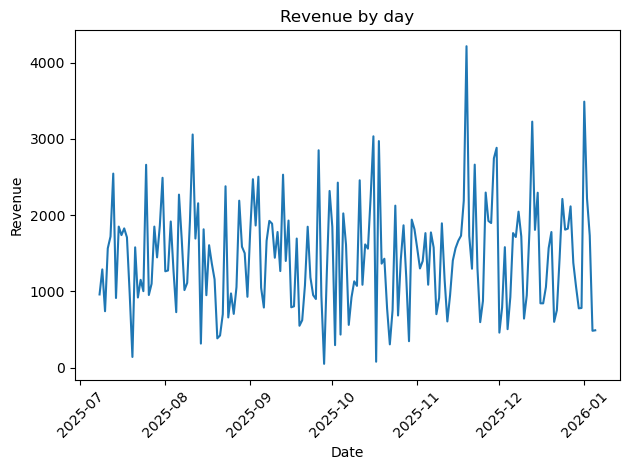

In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_final["dt"], df_final["revenue"])
plt.title("Revenue by day")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Построим столбчатую диаграмму по распределению payment_coverage 

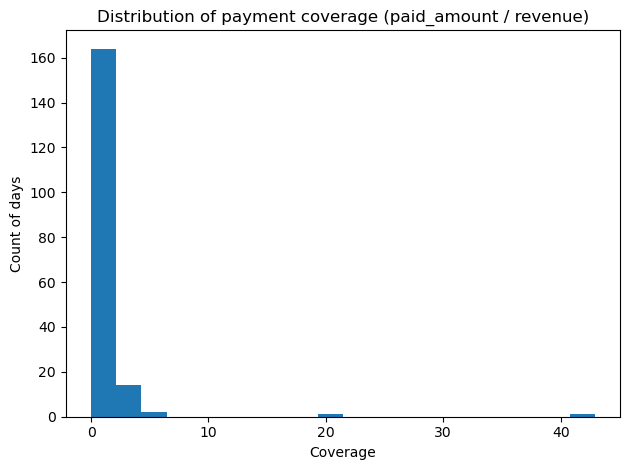

In [35]:
plt.figure()
plt.hist(df_final["payment_coverage"].dropna(), bins=20)
plt.title("Distribution of payment coverage (paid_amount / revenue)")
plt.xlabel("Coverage")
plt.ylabel("Count of days")
plt.tight_layout()
plt.show()

## Сохранение данных в iceberg

Проверим что трино видит iceberg

In [113]:
q("SHOW CATALOGS")

,Catalog
0,iceberg
1,minio
2,mysql
3,postgres
4,system


Посмотрим на схемы в iceberg

In [114]:
q("SHOW SCHEMAS FROM iceberg")

,Schema
0,information_schema
1,system


Создадим схему демо, чтобы проверить что всё работает

In [115]:
q("CREATE SCHEMA IF NOT EXISTS iceberg.demo")

In [116]:
q("SHOW SCHEMAS FROM iceberg")

,Schema
0,demo
1,information_schema
2,system


Проверим smoke_test что создание таблиц работает

In [117]:
q("DROP TABLE IF EXISTS iceberg.demo.smoke_test")

In [118]:
q("""
CREATE TABLE iceberg.demo.smoke_test AS
SELECT 1 AS id, current_timestamp AS ts
""")

,rows
0,1


In [120]:
q("SELECT * FROM iceberg.demo.smoke_test")

,id,ts
0,1,2026-01-06 13:01:00.233000+00:00


Отлично, всё работает. Теперь сохраним в таблицу в iceberg, результат запроса к таблицам из postgres и mysql

In [121]:
q("DROP TABLE IF EXISTS iceberg.demo.daily_finance")

In [122]:
q("""
CREATE TABLE iceberg.demo.daily_finance AS
SELECT
  o.dt,
  o.orders_cnt,
  o.revenue,
  p.payments_cnt,
  p.paid_amount,
  CAST(p.paid_amount / NULLIF(o.revenue, 0) AS double) AS payment_coverage
FROM (
  SELECT
    date_trunc('day', order_ts) AS dt,
    count(*) AS orders_cnt,
    sum(total_amount) AS revenue
  FROM postgres.public.trn_orders
  GROUP BY 1
) o
LEFT JOIN (
  SELECT
    date_trunc('day', paid_at) AS dt,
    count(*) AS payments_cnt,
    sum(amount) AS paid_amount
  FROM mysql.demo_db.trn_payments
  GROUP BY 1
) p
ON o.dt = p.dt
""")

,rows
0,182


Проверим данные что записались

In [123]:
q("SELECT * FROM iceberg.demo.daily_finance ORDER BY dt DESC LIMIT 10")

,dt,orders_cnt,revenue,payments_cnt,paid_amount,payment_coverage
0,2026-01-05,1,488.50,3,573.93,1.174882
1,2026-01-04,2,482.21,4,737.03,1.528442
2,2026-01-03,7,1731.40,6,1621.52,0.936537
3,2026-01-02,8,2220.68,4,593.19,0.267121
4,2026-01-01,9,3489.39,1,104.99,0.030088
5,2025-12-31,3,781.50,4,511.27,0.654216
6,2025-12-30,2,776.72,5,980.97,1.262965
7,2025-12-29,6,1060.51,4,806.94,0.760898
8,2025-12-28,6,1374.46,3,1029.96,0.749356
9,2025-12-27,7,2115.07,7,2112.56,0.998813


Прекрасно, всё отработало, как надо!